In [1]:
%load_ext sql

In [2]:
import datetime
import pandas as pd
import json

from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

In [3]:
%sql postgresql://postgres:postgres@db:5432/postgres

In [4]:
def calendar_is_currently_active(row) -> bool:
    now = datetime.datetime.now()
    start = datetime.datetime.strptime(row['start_date'], '%Y%m%d')
    end = datetime.datetime.strptime(row['end_date'], '%Y%m%d')

    return start <= now <= end

In [5]:
result = %sql SELECT * FROM calendar

currently_active = [
    row
    for row in result.dicts()
    if not calendar_is_currently_active(row)
]

count_currently_active = len(currently_active)

print(f"{count_currently_active} currently active calendars")

 * postgresql://postgres:***@db:5432/postgres
2904 rows affected.
1250 currently active calendars


In [6]:
historic_data_id_to_analyze = 25348

result = %sql SELECT * FROM historic_data WHERE id = :historic_data_id_to_analyze
historic_data = next(result.dicts())

historic_data

 * postgresql://postgres:***@db:5432/postgres
1 rows affected.


{'id': 25348,
 'trip_id': 'bgs:34350: :H:w22',
 'stop_id': 'de:05954:6876:0:02',
 'recording_time': datetime.datetime(2023, 10, 17, 11, 0, 1, 146000),
 'is_departure': True,
 'planned': datetime.datetime(2023, 10, 17, 21, 48),
 'estimated': None,
 'raw_data': '{"location":{"id":"de:05954:6876:0:02","isGlobalId":true,"name":"Hattingen Richard-Dehmel-Str.","type":"platform","coord":[5305703,801927],"properties":{"stopId":"20006876","area":"0","platform":"02"},"parent":{"id":"de:05954:6876","isGlobalId":true,"name":"Hattingen Richard-Dehmel-Str.","disassembledName":"Richard-Dehmel-Str.","type":"stop","parent":{"name":"Hattingen","type":"locality"},"properties":{"stopId":"20006876"}}},"departureTimePlanned":"2023-10-17T21:48:00Z","transportation":{"id":"bgs:34350: :H:w22","name":"Niederflurbus 350","disassembledName":"350","number":"350","description":"Mitte S - Bochum Hbf","product":{"id":13,"class":5,"name":"Niederflurbus","iconId":5},"operator":{"code":"BGSB","id":"34","name":"BOGESTRA 

# Trying to figure out how the trip is encoded

The first part seems to be the route_id. The column `NVBW_DLID` contains contains `de:vrr:bgs-34-350:`.

In [7]:
%%sql SELECT t.*
                 FROM public.routes t
                 WHERE "NVBW_DLID" like '%bgs-34-350%'
                 ORDER BY "NVBW_DLID"
                 LIMIT 501

 * postgresql://postgres:***@db:5432/postgres
1 rows affected.


[('bgs-34-350-1', 'bgs-34', '350', 'Hattingen Mitte S - Welper - Blankenstein - BO-Stiepel - Bochum Hbf', '3', 'FF0000', 'FFFFFF', 'de:vrr:bgs-34-350:')]

Digging deeper into `raw_data` of the data:

In [8]:
parsed = json.loads(historic_data['raw_data'])
print(json.dumps(parsed, indent=2))

print(parsed['transportation']['properties']['globalId'])

{
  "location": {
    "id": "de:05954:6876:0:02",
    "isGlobalId": true,
    "name": "Hattingen Richard-Dehmel-Str.",
    "type": "platform",
    "coord": [
      5305703,
      801927
    ],
    "properties": {
      "stopId": "20006876",
      "area": "0",
      "platform": "02"
    },
    "parent": {
      "id": "de:05954:6876",
      "isGlobalId": true,
      "name": "Hattingen Richard-Dehmel-Str.",
      "disassembledName": "Richard-Dehmel-Str.",
      "type": "stop",
      "parent": {
        "name": "Hattingen",
        "type": "locality"
      },
      "properties": {
        "stopId": "20006876"
      }
    }
  },
  "departureTimePlanned": "2023-10-17T21:48:00Z",
  "transportation": {
    "id": "bgs:34350: :H:w22",
    "name": "Niederflurbus 350",
    "disassembledName": "350",
    "number": "350",
    "description": "Mitte S - Bochum Hbf",
    "product": {
      "id": 13,
      "class": 5,
      "name": "Niederflurbus",
      "iconId": 5
    },
    "operator": {
      "code"

The `globalId` seems to be the same as the `NVBW_DLID` in the `trips` table. Using this we should be able to figure all trips out of our historical data. Lets try.

In [9]:
all_historic_data = %sql SELECT * FROM historic_data

all_historic_data_with_parsed_json = [
    {
        **row,
        'raw_data': json.loads(row['raw_data'])
    }
    for row in all_historic_data.dicts()
]

all_historic_data_that_have_global_id = [
    row
    for row in all_historic_data_with_parsed_json
    if 'globalId' in row['raw_data']['transportation']['properties']
]

all_historic_data_without_global_id = [
    row
    for row in all_historic_data_with_parsed_json
    if 'globalId' not in row['raw_data']['transportation']['properties']
]

print(f"{len(all_historic_data_that_have_global_id)} historic data that have global id, out of {len(all_historic_data)}")

 * postgresql://postgres:***@db:5432/postgres
25348 rows affected.
24751 historic data that have global id, out of 25348


Hmm, not all routes have a global id??? what are these?

In [10]:
all_historic_data_without_global_id[0]['raw_data']['transportation']['properties']


transportations_of_historic_data_without_global_id = [
    row['raw_data']['transportation']
    for row in all_historic_data_without_global_id
]

transportations_of_historic_data_without_global_id

df = pd.DataFrame.from_records(transportations_of_historic_data_without_global_id)
x = df.groupby('name').size().reset_index(name='counts')

# dispaly groups as dataframe
x.sort_values(by=['counts'], ascending=False)

name  counts
95                   SB SB36      86
5          Ersatzverkehr SEV      77
86         Niederflurbus 253      47
90         Niederflurbus 267      47
92       Niederflurstrab 701      43
..                       ...     ...
63  ICE 845 InterCityExpress       1
64  ICE 846 InterCityExpress       1
28  ICE 108 InterCityExpress       1
66  ICE 848 InterCityExpress       1
0          EC 114 Wörthersee       1

[101 rows x 2 columns]

These without a `globalId` seem to be outside of the vrr. Lets just ignore them for now.

Lets try to check if we can find all routes the recorded globalIds in our database.

In [11]:
def find_route_by_global_id(global_id: str):
    result = %sql SELECT * FROM routes WHERE "NVBW_DLID" = :global_id
    if len(result) == 0:
        return None
    return next(result.dicts())

def find_stop_by_stop_id(stop_id: str):
    result = %sql SELECT * FROM stops WHERE "stop_id" = :stop_id
    if len(result) == 0:
        return None
    return next(result.dicts())


all_historic_data_with_their_routes = [
    {
        **row,
        "route": find_route_by_global_id(row['raw_data']['transportation']['properties']['globalId']),
        "stop": find_stop_by_stop_id(row['stop_id'])
    }
    for row in all_historic_data_that_have_global_id
]

 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows affected.
 * postgresql://postgres:***@db:5432/postgres
1 rows af

In [12]:
without_route = [
    row
    for row in all_historic_data_with_their_routes
    if row['route'] is None
]

len(without_route)

without_route_pd = pd.DataFrame.from_records(without_route)
without_route_pd.groupby('trip_id').size().reset_index(name='counts')

trip_id  counts
0  bgs:34NE3: :H:w22       4
1  rbg:72721: :H:j23      11
2  rbg:72721: :R:j23      12
3  rbg:72722: :H:j23       6
4  rbg:72722: :R:j23       4

It seems that we cannot find routes for these entries, but what does that mean?

In [13]:
without_route[3]['raw_data']['transportation']


{'id': 'rbg:72721: :H:j23',
 'name': 'Niederflurbus 721',
 'disassembledName': '721',
 'number': '721',
 'description': 'D-Flughafen Terminal A / B / C - Nordfriedhof - Düsseldorf Hbf - D-Tannenhof, Gothaer Weg',
 'product': {'id': 13, 'class': 5, 'name': 'Niederflurbus', 'iconId': 5},
 'operator': {'code': 'RBG', 'id': '70', 'name': 'Rheinbahn'},
 'destination': {'id': '20018819', 'name': 'D-Gothaer Weg', 'type': 'stop'},
 'properties': {'isSTT': True,
  'isROP': True,
  'tripCode': 303,
  'lineDisplay': 'LINE',
  'globalId': 'de:vrr:rbg-72-721:'},
 'origin': {'id': '20018492',
  'name': 'D-Flughafen Term. A/B/C',
  'type': 'stop'}}

In [14]:
%%sql SELECT t.*
                 FROM public.routes t
                 WHERE "route_id" LIKE '%rbg-72-721%'
                 ORDER BY "NVBW_DLID"
                 LIMIT 501

 * postgresql://postgres:***@db:5432/postgres
1 rows affected.


[('rbg-72-721-1', 'rbg-70', '721', 'D-Flughafen Terminal A / B / C - Nordfriedhof - Düsseldorf Hbf - D-Tannenhof, Gothaer Weg', '3', 'FF0000', 'FFFFFF', None)]

We can find one that has the name name and also matches with the description. These routes dont have an globalID (NVBW_DLID). But this assumes the -1 suffix. I dont know yet what it means. Lets try to break down the `trip_id`.

# Breaking down the trip id

lets checkout a sample data set:

In [15]:
all_historic_data_with_their_routes[0]

{'id': 1,
 'trip_id': 'dvg:21923: :H:j23',
 'stop_id': 'de:05112:16263:0:1',
 'recording_time': datetime.datetime(2023, 10, 9, 18, 38, 8, 235000),
 'is_departure': True,
 'planned': datetime.datetime(2023, 10, 9, 18, 47),
 'estimated': datetime.datetime(2023, 10, 9, 18, 47),
 'raw_data': {'realtimeStatus': ['MONITORED'],
  'isRealtimeControlled': True,
  'location': {'id': 'de:05112:16263:0:1',
   'isGlobalId': True,
   'name': 'DU-Friedrich-Ebert-Str.',
   'disassembledName': '1',
   'type': 'platform',
   'coord': [5306286, 747249],
   'properties': {'stopId': '20016263',
    'area': '0',
    'platform': '1',
    'platformName': '1'},
   'parent': {'id': 'de:05112:16263',
    'isGlobalId': True,
    'name': 'DU-Friedrich-Ebert-Str.',
    'disassembledName': 'Friedrich-Ebert-Str.',
    'type': 'stop',
    'parent': {'name': 'Duisburg', 'type': 'locality'},
    'properties': {'stopId': '20016263'}}},
  'departureTimePlanned': '2023-10-09T18:47:00Z',
  'departureTimeEstimated': '2023-10

```
dvg:21923: :H:j23
^^^^^^------------ Agency Identifier
      ^^^--------- Route Identifier (short)
         ^-------- Separator
          ^ 
```

In [16]:
import re

# the start of each trip id contains the route id
def extract_global_id_route_id_from_trip_id(trip_id: str) -> str:
    regex = r"([a-zA-Z]{3}):(\d\d)([a-zA-Z0-9]{3}):"
    matches = re.search(regex, trip_id)

    groups = matches.groups()

    # any zeros must be removed
    agency_id = int(groups[1])
    # -1 or -2 is still missing here...
    return f"{groups[0]}-{agency_id}-{groups[2]}"

computed_global_route_id = extract_global_id_route_id_from_trip_id(all_historic_data_with_their_routes[0]['trip_id'])
actual_global_route_id = all_historic_data_with_their_routes[0]['raw_data']['transportation']['properties']['globalId']

print(f"computed_global_route_id: {computed_global_route_id}")
print(f"actual_global_route_id: {actual_global_route_id}")

computed_global_route_id: dvg-21-923
actual_global_route_id: de:vrr:dvg-21-923:


There seems to be these prefixes in `NVBW_DLID`:

In [17]:
%sql SELECT SUBSTRING("NVBW_DLID", 1, 6) as "PREFIX", COUNT(*) as "count" FROM public.routes GROUP BY "PREFIX" ORDER BY "count" DESC

 * postgresql://postgres:***@db:5432/postgres
5 rows affected.


[('de:vrr', 1511), (None, 252), ('de:nrw', 63), ('de:vrR', 1), ('de.vrr', 1)]

There seem to be typos :)))) 

It seems that we must determine the routes agency before we can determine the route_id?

Lets try to see if we can determine with trips come into question:

In [18]:
def valid_services_at_date(date: datetime.date) -> any:
    result = %sql SELECT * FROM calendar_dates WHERE TO_DATE(date, 'YYYYMMDD') = :date AND service_id IN (SELECT service_id FROM calendar WHERE TO_DATE(start_date, 'YYYYMMDD') <= :date AND TO_DATE(end_date, 'YYYYMMDD') >= :date)

    return [*result.dicts()]

example_date = all_historic_data_with_their_routes[0]['recording_time'].date()

valid_services_at_date(example_date)

 * postgresql://postgres:***@db:5432/postgres
920 rows affected.


[{'service_id': 'Special#490', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#491', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#225', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#6', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#342', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#271', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#311', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#144', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#147', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#54', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#56', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#439', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#441', 'date': '20231009', 'exception_type': '1'},
 {'service_id': 'Special#68',

In [27]:
# gets all trips that were active for that date

date = all_historic_data_with_their_routes[0]['recording_time'].date()

print(f"trip_id '{all_historic_data_with_their_routes[0]['trip_id']}'")
print(f"computed_global_route_id: '{computed_global_route_id}'")

padded_computed_global_route_id = f"%{computed_global_route_id}%"

%sql SELECT * FROM trips WHERE trip_id LIKE :padded_computed_global_route_id AND service_id IN (SELECT service_id FROM calendar_dates WHERE TO_DATE(date, 'YYYYMMDD') = :date AND service_id IN (SELECT service_id FROM calendar WHERE TO_DATE(start_date, 'YYYYMMDD') <= :date AND TO_DATE(end_date, 'YYYYMMDD') >= :date))

trip_id 'dvg:21923: :H:j23'
computed_global_route_id: 'dvg-21-923'
 * postgresql://postgres:***@db:5432/postgres
65 rows affected.


[('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-34-53', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-35-54', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-36-55', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-33-56', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-37-57', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-38-58', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-39-59', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-40-61', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-41-62', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-42-64', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-43-65', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-44-67', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-45-68', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-46-70', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-47-71', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-48-73', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-49-74', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-50-76', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-51-77', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-52-79', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-53-80', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-54-82', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-55-83', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-56-85', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-57-86', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-58-88', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-59-89', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-60-91', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-61-92', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-8-R-0-Special#7-62-94', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#225', 'dvg-21-923-1-1-8-R-0-Special#225-65-95', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#225', 'dvg-21-923-1-1-8-R-0-Special#225-66-96', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#225', 'dvg-21-923-1-1-8-R-0-Special#225-67-97', None, None, None, '1', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-5-H-0-Special#7-1-1', None, None, None, '0', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-5-H-0-Special#7-2-2', None, None, None, '0', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-5-H-0-Special#7-3-3', None, None, None, '0', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-5-H-0-Special#7-4-4', None, None, None, '0', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-5-H-0-Special#7-5-5', None, None, None, '0', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-5-H-0-Special#7-6-6', None, None, None, '0', '2'),
 ('dvg-21-923-1', 'Special#7', 'dvg-21-923-1-1-5-H-0-Special#7-7-8', None, None, None, '0', '2'),
 (

 * postgresql://postgres:***@db:5432/postgres
179848 rows affected.


<Axes: xlabel='unknown_2'>

<Axes: xlabel='unknown_3'>

<Axes: xlabel='unknown_4'>

<Axes: xlabel='unknown_5'>

array([  4,  11,  15,  34,   3,   5,   1,   2,   6,  13,   9,   8,  10,
        12,  14,   7,  41,  27,  21,  45,  36,  17,  39,  24,  46,  30,
        23,  28,  18,  52,  42,  56,  55,  38,  50,  37,  51,  19,  20,
        26,  25,  49,  33,  16,  48,  54,  53,  22,  43,  44,  40,  29,
        47,  31,  32,  61,  62,  63,  57,  58,  60,  35,  98,  99,  85,
        86,  87,  92, 101,  80, 182, 128, 186, 166, 105, 104,  74,  69,
        95,  93,  96,  94,  81,  76,  77,  82,  83,  79, 181, 178, 119,
        89,  90,  64,  67,  78,  70,  65,  75,  66,  72,  59,  68,  71,
        73, 201, 103, 321, 326, 327, 330, 331, 195, 264, 267, 269, 270,
       271, 263, 121, 196, 323, 335, 337, 338, 333, 197, 276, 277, 280,
       275, 344, 346, 348, 350, 199, 279, 282, 287, 288, 291, 292, 293,
       351, 352, 268, 296, 355, 357, 302, 303, 305, 306, 140, 358, 360,
       132, 130, 131,  97,  84, 110, 111, 116,  88, 100, 361, 362, 297,
       312, 314, 315, 316, 318, 295, 129, 363, 106, 273, 146, 36

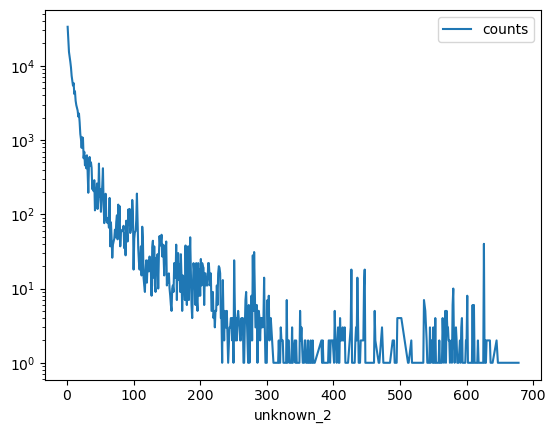

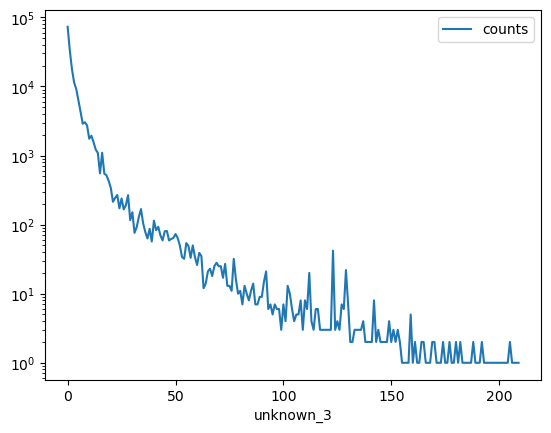

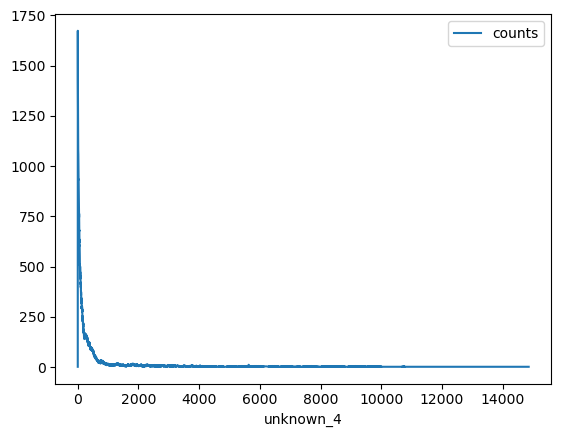

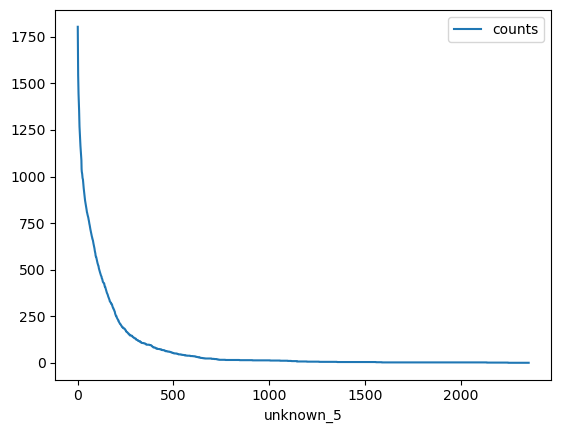

In [95]:
from typing import Callable

data = %sql SELECT * FROM public.trips

def split_by_char_to_groups(char: str, start_group: int, end_group: int) -> Callable[[str], str]:
    def split_by_char_to_groups_inner(s: str) -> str:
        return char.join(s.split(char)[start_group:end_group])
    
    return split_by_char_to_groups_inner



trips = pd.DataFrame.from_records(data.dicts())
trips['__agency_id'] = trips['trip_id'].apply(split_by_char_to_groups('-', 0, 2))
trips['__route_id'] = trips['trip_id'].apply(split_by_char_to_groups('-', 0, 4))
trips['unknown_1_maybe_a_date'] = trips['trip_id'].apply(split_by_char_to_groups('-', 4, 5))
trips['unknown_2'] = trips['trip_id'].apply(split_by_char_to_groups('-', 5, 6)).astype(int)
trips['__direction'] = trips['trip_id'].apply(split_by_char_to_groups('-', 6, 7))
trips['unknown_3'] = trips['trip_id'].apply(split_by_char_to_groups('-', 7, 8)).astype(int)
trips['__calendar'] = trips['trip_id'].apply(split_by_char_to_groups('-', 8, 9))
trips['unknown_4'] = trips['trip_id'].apply(split_by_char_to_groups('-', 9, 10)).astype(int)
trips['unknown_5'] = trips['trip_id'].apply(split_by_char_to_groups('-', 10, 11)).astype(int)

display(trips['unknown_2'].groupby(trips['unknown_2']).size().reset_index(name='counts').plot.line(x='unknown_2', y='counts', logy=True))
display(trips['unknown_3'].groupby(trips['unknown_3']).size().reset_index(name='counts').plot.line(x='unknown_3', y='counts', logy=True))
display(trips['unknown_4'].groupby(trips['unknown_4']).size().reset_index(name='counts').plot.line(x='unknown_4', y='counts'))
display(trips['unknown_5'].groupby(trips['unknown_5']).size().reset_index(name='counts').plot.line(x='unknown_5', y='counts'))

trips['unknown_2'].unique()

# trips['unknown_5'].groupby(trips['unknown_5']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)